In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
    
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'

# minus 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리

In [2]:
df = pd.read_csv("./data/latib_db_reviews.csv")

In [3]:
df = df.drop(columns='_id')
df = df.drop_duplicates()

In [4]:
df = df.reset_index().drop(columns='index')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8605 entries, 0 to 8604
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   8605 non-null   object 
 1   product_price  8605 non-null   int64  
 2   content        8601 non-null   object 
 3   option         562 non-null    object 
 4   date           8592 non-null   object 
 5   rating         8592 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 403.5+ KB


### 레이팅과 데이트의 Nan 항목이 같은지 확인

In [6]:
df[df['rating'].isna()]

,product_name,product_price,content,option,date,rating
10,ABC JUICE,43000,"건강식을 워낙 좋아하기는 하지만, 라티브 ABC 주스는 딱 먹자마자 와!하는 감탄이...",NaN,NaN,NaN
11,ABC JUICE,43000,NaN,NaN,NaN,NaN
1042,ABC JUICE,43000,일단 매일쾌*..!!!\n섬유질이 많아서 그런지 포만감도 있고 두번째 재 주문하여 ...,NaN,NaN,NaN
2038,ABC JUICE,43000,"포장도 예쁘고 몸에도 좋을거같긴한데 안달고 너무 건강한 맛이에요,,,,\n\n(20...",NaN,NaN,NaN
5536,ABC JUICE,43000,먹기편리하고 믿음이갑니다,NaN,NaN,NaN
5807,ABC JUICE,43000,깔끔한포장에 섭취하기 편리함까지 좋습니다\n맛도 나쁘지않아요^^\n배송은 좀 걸렸어요~,NaN,NaN,NaN
6063,CCA JUICE,40600,채정안주스 기대가 됩니다 ㅎㅎ,NaN,NaN,NaN
6064,CCA JUICE,40600,NaN,NaN,NaN,NaN
6349,SALAD JUICE,43000,생각보다 맛나요 몸에좋을거라고 생각하고 먹어요\n\n\n(2024-02-03 스마트...,NaN,NaN,NaN
6350,SALAD JUICE,43000,NaN,NaN,NaN,NaN


### 벌점 없는 데이터는 사용 불가능이므로 드롭

In [7]:
df = df.dropna(subset=['rating'])

In [8]:
# 비정상적인 데이터 확인
invalid_dates = df[~df['date'].str.contains(r'^\d{4}\.\d{1,2}\.\d{1,2}$')]
print("Invalid dates:")
print(invalid_dates['date'])

Invalid dates:
136     2024.4.29 수정 및 삭제
137     2024.4.29 수정 및 삭제
138     2024.4.29 수정 및 삭제
139     2024.4.29 수정 및 삭제
140     2024.4.29 수정 및 삭제
              ...        
8114    2024.3.21 수정 및 삭제
8115    2024.3.21 수정 및 삭제
8116    2024.3.21 수정 및 삭제
8117    2024.3.21 수정 및 삭제
8118    2024.3.21 수정 및 삭제
Name: date, Length: 167, dtype: object


In [9]:
# 숫자와 점만 추출
df['date'] = df['date'].str.extract(r'(\d{4}\.\d{1,2}\.\d{1,2})')

# datetime으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y.%m.%d')

# YY-MM 형식으로 Month 컬럼 생성
df['Month'] = df['date'].dt.strftime('%y-%m')

In [10]:
df

,product_name,product_price,content,option,date,rating,Month
0,ABC JUICE,43000,아직 먹기 전 인데 신선해 보이네요! 후기가 좋길래\n샀어요!,60포 (15% 할인 + 무료배송),2023-09-27,5.00,23-09
1,ABC JUICE,43000,저는 맛이..잘못먹는데 남편은 속이 편해진다고\n술먹고도 너무 잘먹더라구요\n저는 ...,10포 (클렌즈 5일 플랜),2023-07-01,5.00,23-07
2,ABC JUICE,43000,진짜 너뮤 맛있어서 받자마자 행복하게 먹었어요 바로 구독 결정 합니다 ㅎㅎ,20일 (ABC주스 20포),2025-01-16,5.00,25-01
3,ABC JUICE,43000,맛있어서 계속 구매할거같아요.,10일 (ABC주스 10포),2024-09-15,5.00,24-09
4,ABC JUICE,43000,매번 구입하는 제품입니다. 속이 편해서 꾸준히 먹고 있어요,10일 (ABC주스 10포),2024-05-25,5.00,24-05
...,...,...,...,...,...,...,...
8600,BREATHE JUICE,43000,ㅠㅠ\n애들 주려고샀는데 남편이 더 먹어요\n문제는 세네개씩먹는데 괜찮을까요,NaN,2020-06-17,5.00,20-06
8601,BREATHE JUICE,43000,"완전 원액그대로 넣은거 같아요, 알갱이도 씹히고. 맛도 맛잇어요!\n\n(2020-...",NaN,2020-06-17,5.00,20-06
8602,BREATHE JUICE,43000,신세계네요\n아침일찍 출근이 너무너무 피곤하고 힘든 서른살 일인입니댜..매번 아침에...,NaN,2020-06-16,5.00,20-06
8603,BREATHE JUICE,43000,선물용으로 좋아요\n박스가 고급스럽네요\n건강하게 약이될거같은 단맛\n좋아요\n리뷰...,NaN,2020-06-15,5.00,20-06


# 시각화

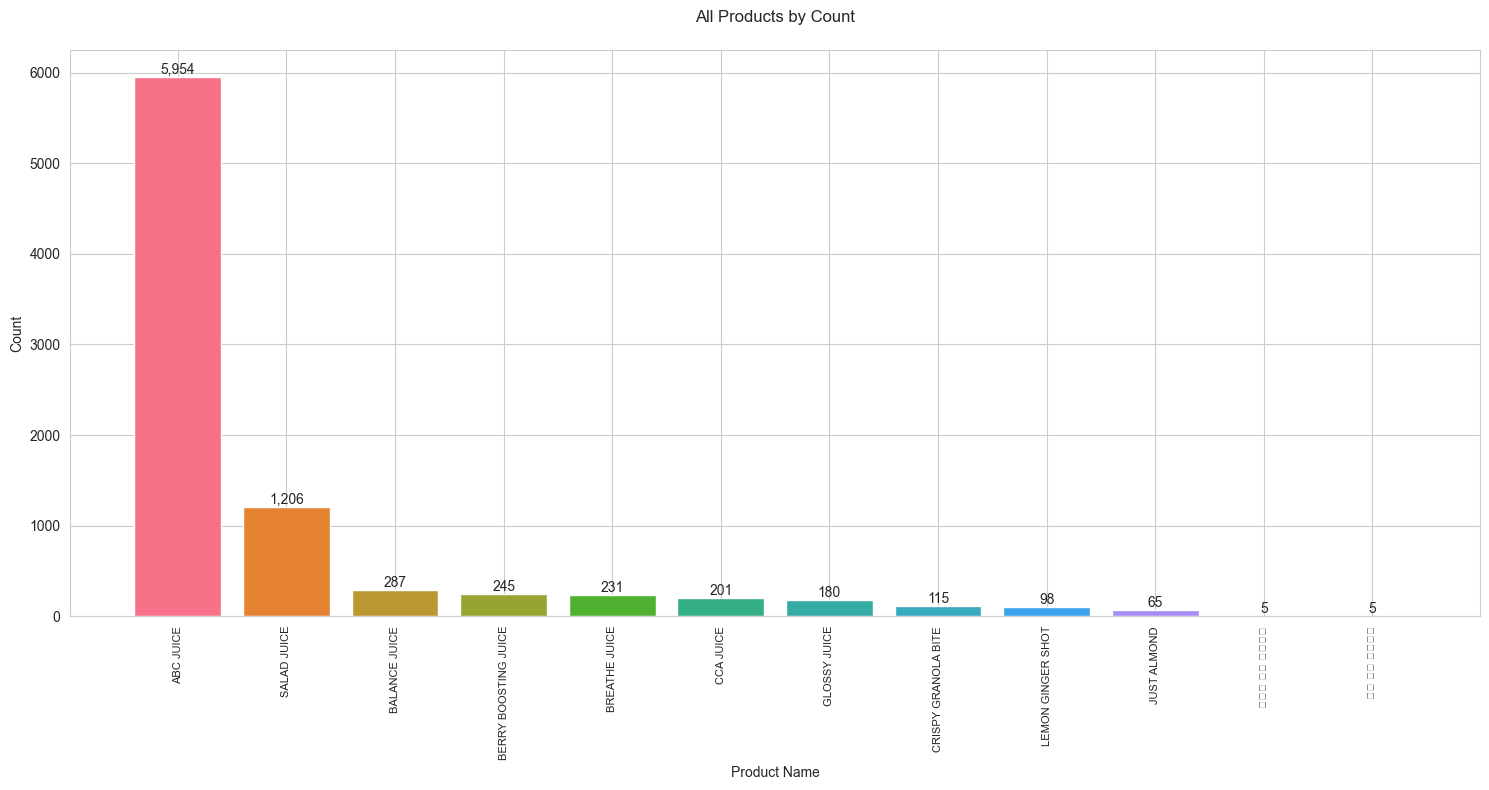

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import matplotlib.font_manager as fm

# 정확한 폰트명으로 설정
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams['axes.unicode_minus'] = False

# product_name 전체 카운팅
product_counts = df['product_name'].value_counts()

# seaborn 스타일 설정
sns.set_style("whitegrid")

# 그래프 크기 설정
plt.figure(figsize=(15, 8))

# 팔레트 설정
colors = sns.color_palette("husl", len(product_counts))

# 막대 그래프 생성
bars = plt.bar(range(len(product_counts)), product_counts.values, color=colors)

# 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.xticks(range(len(product_counts)), product_counts.index, rotation=90, fontsize=8)

# 제목과 라벨
plt.title('All Products by Count', pad=20)
plt.xlabel('Product Name')
plt.ylabel('Count')

# 여백 조정
plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()